In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn import model_selection
from sklearn.metrics import accuracy_score
import xgboost as xgb
import warnings
import matplotlib.pyplot as plt
import torch

warnings.filterwarnings('ignore')

In [10]:
def RFF_sample(n, shape):
    w = torch.randn(n)
    phi = 2*np.pi*torch.rand(n)
    if(shape == 2):
        return lambda x:np.sqrt(2)*torch.cos(w[:,None]*x[None,:]+phi[:,None])
    else:
        return lambda x:np.sqrt(2)*torch.cos(w[:,None,None]*x[None,:,:]+phi[:,None,None])

def hat_sigma(A, B, weights):
    nA, n, _ = A.shape
    wA = (weights[None,:, None]*A - torch.mean(weights[None,:, None]*A, axis=1)[:, None, :]).transpose(0,1).transpose(1,2)[:,:,:,None]
    wB = (weights[None, :]*B - torch.mean(weights[None, :]*B, axis=1)[:, None]).transpose(0,1)[:,None,None,:]
    return torch.sum(wA*wB, axis=0)/(n-1)

def F_norm2(A, i):
    return torch.sum(A**2) - torch.sum(A[i]**2)

u, v = RFF_sample(5,3), RFF_sample(5,2)
X, Y = torch.randn((10000, 64)), torch.randn(10000)
print(F_norm2(hat_sigma(u(X), v(Y), torch.ones(10000)), 0))
print(F_norm2(hat_sigma(u(X), v(X[:,0]**2), torch.ones(10000)), 0))

tensor(0.0229)
tensor(0.0406)


In [11]:
import torch.nn as nn
import torch.nn.functional as F
    
class AttentionRepresentation(nn.Module):
    def __init__(self, n_team_fts, hidden_team):
        super().__init__()
        self.hidden = hidden_team
        self.bc1 = nn.BatchNorm1d(n_team_fts)
        self.bc2 = nn.BatchNorm1d(hidden_team)
        self.att1 = nn.MultiheadAttention(hidden_team, 1, batch_first=True)
        self.fc1 = nn.Linear(n_team_fts, hidden_team)

    def forward(self, x):
        res = self.bc2(self.fc1(self.bc1(x)))[:,None,:]
        res = self.att1(res, res, res, need_weights=False)[0]
        return res[:,0,:]
    
    def activate(self, require):
        self.bc1.requires_grad_(require)
        self.bc2.requires_grad_(require)
        self.att1.requires_grad_(require)
        self.fc1.requires_grad_(require)
    

class MatchTeamClassifier(nn.Module):
    def __init__(self, n_class, n_team_fts, hidden_team):
        super().__init__()
        self.phi = AttentionRepresentation(n_team_fts, hidden_team)
        self.fc = nn.Linear(hidden_team, n_class)

    def forward(self, x):
        return self.fc(self.phi(x))
    
    def activate(self, require):
        self.phi.activate(require)
        self.fc.requires_grad_(require)

In [12]:
train_home_team_statistics_df = pd.read_csv('./train_home_team_statistics_df.csv', index_col=0)
train_away_team_statistics_df = pd.read_csv('./train_away_team_statistics_df.csv', index_col=0)
test_away_team_statistics_df = pd.read_csv('./test_away_team_statistics_df.csv', index_col=0)
test_home_team_statistics_df = pd.read_csv('./test_home_team_statistics_df.csv', index_col=0)


train_scores = pd.read_csv('./Y_train.csv', index_col=0)

train_home_team_statistics_df.columns = 'HOME_' + train_home_team_statistics_df.columns
train_away_team_statistics_df.columns = 'AWAY_' + train_away_team_statistics_df.columns

train_data = train_home_team_statistics_df.iloc[:,2:].join(train_away_team_statistics_df.iloc[:,2:])

In [13]:
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(train_data, train_scores, train_size=0.8, random_state=42)

In [14]:
net = MatchTeamClassifier(3, 280, 64)

x_train = torch.Tensor(X_train.replace({np.nan:0.0}).values)
x_valid = torch.Tensor(X_valid.replace({np.nan:0.0}).values)
Y_train = torch.Tensor(y_train.values)
Y_valid = torch.Tensor(y_valid.values)

print(net(x_valid).shape)
net.phi.bc1.requires_grad_(False)


torch.Size([2461, 3])


BatchNorm1d(280, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [33]:
from torchmin import minimize_constr
def Frobenius_loss(A, B, u, v):
    _, d = B.shape
    def Loss(weights):
        loss = torch.tensor(0.0)
        for i in range(d):
            loss += F_norm2(hat_sigma(u(A), v(B[:,i]), weights), i)
        return loss
    return Loss

torch.set_grad_enabled(True)
u, v = RFF_sample(5,3), RFF_sample(5,2)
X, Y = net.phi(x_train), net.phi(x_train)
res = minimize_constr(Frobenius_loss(net.phi(x_train), net.phi(x_train), u, v), torch.ones(x_train.shape[0]), max_iter=10, constr=dict(fun=lambda x: x.mean(), lb=1, ub=1),disp=2)

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn

In [15]:
import copy

torch.set_flush_denormal(True)
N_EPOCHS = 10000 # + 100
net.train()
criterion = nn.CrossEntropyLoss(reduction='none') # loss

optimizer = torch.optim.Adam(net.parameters(), lr=0.005, weight_decay=5e-2)

sample_weights = torch.ones(x_train.shape[0])
weights_optimizer = torch.optim.Adam([sample_weights], lr=0.005, weight_decay=5e-2)
u, v = RFF_sample(5,3), RFF_sample(5,2)
weight_rate = 2

train_accuracies = [1.0]
val_accuracies = [1.0]
val_check = 1
best_state, best_val = None, 0.0
for epoch in range(N_EPOCHS):  # loop over the dataset multiple times
    # Iterate over batches and perform optimizer step on the model.
    sample_weights.requires_grad_(False)
    net.activate(True)
    optimizer.zero_grad()
    y_pred = net(x_train)
    loss = criterion(y_pred, Y_train)
    loss = (loss*sample_weights).mean()
    loss.backward()
    optimizer.step()

    # perform optimizer step on the sample weights
    sample_weights.requires_grad_(True)
    net.activate(False)

    for j in range(weight_rate):
        weights_optimizer.zero_grad()
        F_loss = torch.tensor(0.0)
        for i in range(64):
            F_loss += F_norm2(hat_sigma(u(net.phi(x_train)), v(net.phi(x_train)[:,i]), sample_weights), i)
    
        F_loss += 500/(sample_weights).mean()
        F_loss.backward()
        weights_optimizer.step()
        print("moy(w) = ", sample_weights.mean().item())
        
    train_acc, val_acc = accuracy_score(torch.argmax(y_pred, axis=1), torch.argmax(Y_train, axis=1)), val_accuracies[-1]
    if(epoch % val_check == 0):
        hat_y_val = net(x_valid)
        #val_loss = criterion(hat_y_val, y_val)
        val_acc = accuracy_score(torch.argmax(hat_y_val, axis=1), torch.argmax(Y_valid, axis=1))
        if(val_acc > best_val):
            best_val = val_acc
            best_state = copy.deepcopy(net.state_dict())

    val_accuracies.append(val_acc)
    train_accuracies.append(train_acc)
    print(f"Epoch {epoch} Loss {loss.detach().cpu().numpy():.2f} | Train Accuracy {train_acc} | Val Accuracy {val_acc}")

moy(w) =  0.9950252175331116
moy(w) =  0.9900636076927185
Epoch 0 Loss 1.12 | Train Accuracy 0.3173135541556594 | Val Accuracy 0.4380333197887038
moy(w) =  0.9851794838905334
moy(w) =  0.9802584648132324
Epoch 1 Loss 1.03 | Train Accuracy 0.46108514529567163 | Val Accuracy 0.4668833807395368
moy(w) =  0.9753408432006836
moy(w) =  0.9704300761222839
Epoch 2 Loss 1.01 | Train Accuracy 0.47835805730542574 | Val Accuracy 0.47622917513206015
moy(w) =  0.9656331539154053
moy(w) =  0.9609391093254089
Epoch 3 Loss 0.99 | Train Accuracy 0.48679130258077624 | Val Accuracy 0.481511580658269
moy(w) =  0.9564319252967834
moy(w) =  0.9520954489707947
Epoch 4 Loss 0.98 | Train Accuracy 0.4899410688884373 | Val Accuracy 0.48029256399837467
moy(w) =  0.9479309320449829
moy(w) =  0.9439281225204468
Epoch 5 Loss 0.97 | Train Accuracy 0.4944117049380207 | Val Accuracy 0.48598130841121495
moy(w) =  0.940066933631897
moy(w) =  0.9363423585891724
Epoch 6 Loss 0.96 | Train Accuracy 0.4970534444218655 | Val Ac

KeyboardInterrupt: 

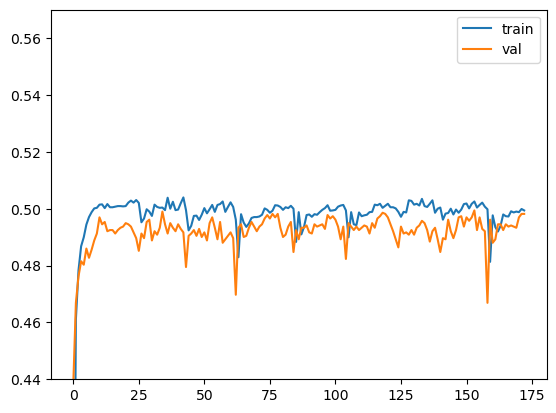

In [16]:
import matplotlib.pyplot as plt

plt.plot(np.arange(len(train_accuracies[1:])), train_accuracies[1:], label = "train")
plt.plot(np.arange(len(train_accuracies[1:])), val_accuracies[1:], label = "val")
plt.legend(loc="best")
plt.ylim(0.44, 0.57)
plt.show()

In [17]:
torch.save(best_state, "MCTstable_params_best_r_2")
torch.save(net.state_dict(), "MCTstable_params_last")

In [18]:
net.load_state_dict(torch.load("MCTstable_params_best_r_2"))
print(accuracy_score(torch.argmax(net(torch.Tensor(train_data.replace({np.nan:0.0}).values)), axis=1), torch.argmax(torch.tensor(train_scores.values), axis=1)))

0.5003657644476956


In [19]:
test_away_team_statistics_df = pd.read_csv('./test_away_team_statistics_df.csv', index_col=0)
test_home_team_statistics_df = pd.read_csv('./test_home_team_statistics_df.csv', index_col=0)

test_home_team_statistics_df.columns = 'HOME_' + test_home_team_statistics_df.columns
test_away_team_statistics_df.columns = 'AWAY_' + test_away_team_statistics_df.columns

test_data = test_home_team_statistics_df.join(test_away_team_statistics_df)

d = {'HOME_WINS':[0 for i in range(len(test_data))], 'DRAW':[0 for i in range(len(test_data))], "AWAY_WINS":[0 for i in range(len(test_data))]}
test_score = pd.DataFrame(data=d, index=test_home_team_statistics_df.index)

y_pred = net(torch.Tensor(test_data.replace({np.nan:0.0}).values))
team_scores = torch.argmax(y_pred, axis=1)
print(team_scores)
test_score.iloc[team_scores == 0, 0] = 1
test_score.iloc[team_scores == 1, 1] = 1
test_score.iloc[team_scores == 2, 2] = 1

test_score.reset_index(inplace=True)
test_score.to_csv("MCTstable.csv", index=False)

tensor([0, 2, 0,  ..., 0, 0, 0])
